In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
tl_core = 20
tl_gap = 12
tl_ground = 10

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [23]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

def draw_single_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length, open_length):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start_x, central_line_y), 
                                                                (coupler_start_x+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core],[resonator_gap, resonator_gap, tl_gap, tl_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed enfd of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(2,3)])

    # 6. Create closed meander of resonator
    closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length,restricted_scale=400, constant_scale=900, radius=40)

    # 7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

    # 10. Create closed meander of resonator
    open_end_resonator = elements.OpenEnd(name='open end',position=(fanout_for_open_end.get_terminals()['down'].position[0],
                                                                   fanout_for_open_end.get_terminals()['down'].position[1]-open_length),
                                         w=resonator_core,
                                         s=resonator_gap,
                                         g=tl_ground,
                                         orientation=np.pi/2,
                                         layer_configuration=sample.layer_configuration,
                                         gap_length=20,
                                         ground_length=10,
                                         cap=10e-15)
    sample.add(open_end_resonator)
    sample.connect_cpw(fanout_for_open_end,open_end_resonator,'down','wide',name='right open end',points=[])
    # 11. Create grounding of resonator
    resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2

In [24]:
g1, g2 = draw_single_resonator(coupler_start, central_line_y, coupler_length,
                        resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                        closed_end_meander_length=2300, open_length=1000)
g3, g4 = draw_single_resonator(coupler_start+1000, central_line_y, coupler_length,
                        resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                        closed_end_meander_length=2500, open_length=1100)
# 5. Create left part of transmission line
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])
# 9. Create middle part of transmission line
middle_TL = sample.connect_cpw(o1=g3, o2=g2, port1='narrow', port2='narrow', name='middle TL', points=[])
# 9. Create left part of transmission line
right_TL = sample.connect_cpw(o1=p2, o2=g4, port1='port', port2='narrow', name='right TL', points=[])

In [25]:
design = sample.draw_design()
sample.watch()

..\QCreator\general_sample_creator.py:337: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


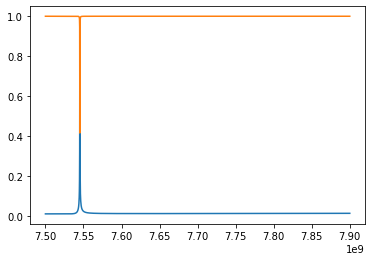

In [7]:
f_ = np.linspace(7.5e9, 7.9e9, 2001)
s11 = sample.get_s21('p1', 'p1', f_)
s21 = sample.get_s21('p1', 'p2', f_)
from matplotlib import pyplot as plt
plt.plot(f_, np.abs(s11))
plt.plot(f_, np.abs(s21))

In [10]:
sys.elements

[Short ,
 Port p1,
 Port p2,
 TL TL-resonator coupler (n=3),
 TL closed end resonator fanout_group1 (n=2),
 TL closed end resonator fanout_group2 (n=1),
 R cl10,
 TL cl1 (n=1),
 TL closed end (n=1),
 TL open end resonator fanout_group0 (n=1),
 TL open end resonator fanout_group1 (n=2),
 R cl20,
 TL cl2 (n=1),
 C open_end,
 TL right open end (n=1),
 Short ,
 TL left TL (n=1),
 TL right TL (n=1)]

In [9]:
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
f[:3]/(2*np.pi)/1e9, delta[:3]/1e6,f[:3]/delta[:3]/2 

(array([ 7.5452374 ,  7.93622331, 16.24200227]),
 array([5.19584400e-01, 6.93191388e+04, 6.60440206e+04]),
 array([4.56211972e+04, 3.59675283e-01, 7.72602190e-01]))

In [14]:
import resonator_tools
from resonator_tools.circuit import notch_port, reflection_port

In [15]:
fitter = notch_port(f_data=f_, z_data_raw=s21)

In [16]:
fitter.autofit()

E:\py38\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


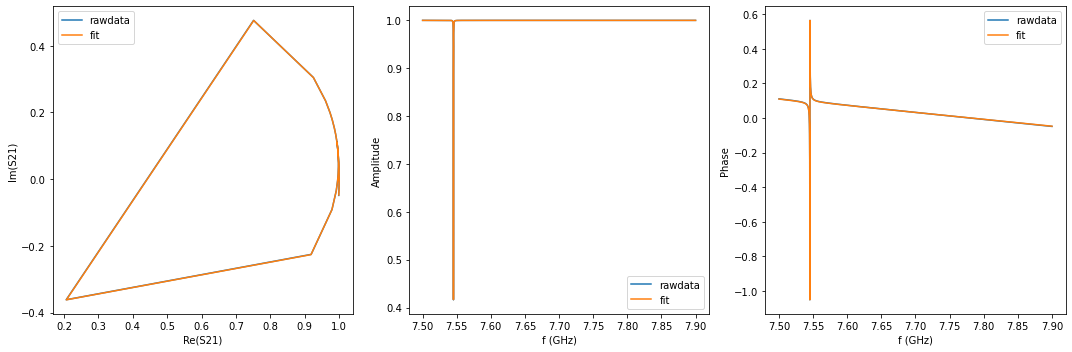

In [17]:
fitter.plotall()

In [18]:
fitter.fitresults

{'Qi_dia_corr': -1919232872.7446785,
 'Qi_no_corr': -1533741448.055106,
 'absQc': 45616.020350184794,
 'Qc_dia_corr': 45616.292853804574,
 'Ql': 45617.37708681348,
 'fr': 7545237553.816003,
 'theta0': -3.1381361154144947,
 'phi0': 0.003456538175298392,
 'chi_square': 5.714774390817395e-07,
 'delay': 6.325242458954729e-11,
 'a': 0.999910307257359,
 'alpha': 3.0921523418684043}

In [4]:
def draw_double_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length1, open_length1, closed_end_meander_length2, open_length2):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                                (coupler_start+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core, resonator_ground, resonator_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap, resonator_gap, resonator_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 4])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(0,1), (3,4)])

    # 6. Create closed meander of resonator
    closed_end_meander1 = sample.connect_meander(name='closed end 1', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length1,restricted_scale=400, constant_scale=900, radius=0)
    
    closed_end_meander2 = sample.connect_meander(name='closed end 2', o1=fanout_for_closed_end, port1='down',
                                                meander_length=closed_end_meander_length2,restricted_scale=400, constant_scale=900, radius=0)

    # 7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 4])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1), (3,4)])

    # 10. Create closed meander of resonator
    open_end_resonator1 = elements.CPW(name='open end resonator 1', points=[fanout_for_open_end.get_terminals()['down'].position, 
                                                                         (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                          fanout_for_open_end.get_terminals()['down'].position[1]-open_length1)],
                                      w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                      g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator1)
    sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator1, 'port1', 0)))
    
    open_end_resonator2 = elements.CPW(name='open end resonator 2', points=[fanout_for_open_end.get_terminals()['up'].position, 
                                                                         (fanout_for_open_end.get_terminals()['up'].position[0],
                                                                          fanout_for_open_end.get_terminals()['up'].position[1]+open_length2)],
                                      w=fanout_for_open_end.get_terminals()['up'].w, s=fanout_for_open_end.get_terminals()['up'].s,
                                      g=fanout_for_open_end.get_terminals()['up'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator2)
    sample.connections.append(((fanout_for_open_end, 'up', 0), (open_end_resonator2, 'port1', 0)))

    # 11. Create grounding of resonator
    resonator_ground_1 = sample.ground(o=closed_end_meander1, port='port2', name='resonator ground 1', grounding_width=30, grounding_between = [(0,2)])
    resonator_ground_2 = sample.ground(o=closed_end_meander2, port='port2', name='resonator ground 2', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2